<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-2:-The-Rescue" data-toc-modified-id="Project-2:-The-Rescue-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project 2: The Rescue</a></span><ul class="toc-item"><li><span><a href="#Deliverables" data-toc-modified-id="Deliverables-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Deliverables</a></span></li><li><span><a href="#Sensors-and-controllers-allowed" data-toc-modified-id="Sensors-and-controllers-allowed-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Sensors and controllers allowed</a></span></li></ul></li><li><span><a href="#Notes" data-toc-modified-id="Notes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notes</a></span></li></ul></div>

## Project 2: The Rescue

Your Zumo has a new mission. Your company's building has been taken over by hostile zombies who have chewed through all of the ethernet cables linking your servers' intellectual property to the cloud. Your company is abandoning the facility, but they need you to retrieve some solid state hard drives that contain the company's valuable information.  As it turns out, your zumo robot is immune to zombie bites and is quite capable of plowing through crowds of zombies with its trusty front blade. 

Since they know you were working on a model of your zumo, they thought you might be able to program it to move through the building autonomously. Specifically, your robot will need to enter the company building from the outside, retrieve the hard drives from the server room, and bring them back outside.

Using a map of the building, you will need to plan out a path for your zumo to follow using 4 "waypoints," each separated by a known distance and a known angle. Luckily, you know that Arduino (and thus Zumo) can keep track of [arrays](https://www.arduino.cc/reference/en/language/variables/data-types/array/) of reference headings and reference distances.  Thankfully you also know that you'll be able to control your zumo's speed & distance using feedback control on its [encoders](https://www.pololu.com/docs/0J63/3.4), and its yaw rate (angular velocity about the z-axis) by using feedback control on the zumo's [gyroscope](https://www.pololu.com/docs/0J57/3.d)  

Your map of the building might look something like the following figure:

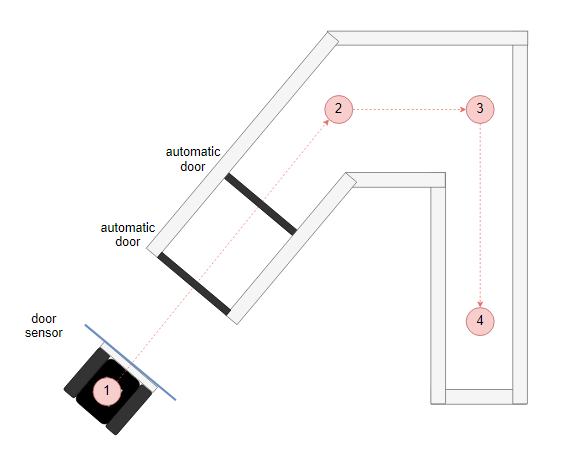

In order to enter the building the Zumo must first get through the automatic doors at the building entrance. The first door is located $0.15m$ from the door's presence sensor and the second door is $0.15m$ past the first door. Your robot will start with the blade just in front of the presence sensor.  

For security, the second door opens after the first. Your Zumo will clear both doors if it reaches the first door in 0.9-1.1 seconds after the mission begins, and reaches the second door in 1.8-2.2 seconds after the mission begins. If your robot goes too fast or too slow on the first leg of the journey, it will not make it inside the building!

The zombies learn quickly. By the time the zumo is exiting the building, they will surely have cut the power and jammed the zumo's sensors.  That means the last leg (waypoint 2 to 1) will need to be completed with open-loop control. It is important that your zumo returns as closely as possible to your original start position to deliver the hard drive to your team.  However, with the power cut the doors will be locked OPEN allow you to leave at any speed you want.


### Deliverables

Design a state machine and a set of feedback controllers that employs a user provided array of distances and angles between each waypoint to move the zumo through the building. The state machine will activate appropriate feedback controllers for traveling (straight) to each waypoint, turning to face the next waypoint, and so on.  When your Zumo reaches waypoint 4 it will turn around and "retrace its steps" to return to waypoint 1. The doors will be active on your way into the building, but with the power getting cut while you are inside, the doors will simply be held open on your way out.

Your goal should be to complete the mission with maximum accuracy from waypoint to waypoint.  Although speed is valued, it should not come at the cost of accuracy, because getting lost in the building will certainly mean an untimely end for your zumo! We will provide practice tracks with "scoring zones" so you can make informed decisions about speed and accuracy. The practice and demonstration day tracks will be 3' x 5' (about the size of your lab benches).

**Similarly to project 1, You will be asked to populate a Jupyter "report" notebook that documents your design process & decisions.**  You will have a bit more to discuss as you have more decisions to make.  Some questions you will need to able to answer in your report are:

* How did you pick target eigenvalues when designing your controller(s)?
* How did you design each controller to hit those target eigenvalues?
* What is the agreement between the predicted and actual system response to standard inputs (e.g. step) for each of the controllers in your design?
* How did you deal with physical limitations of your models and/or the robot? For instance, how important were nonlinearities? Maximum voltage available from the batteries?

**This report is due by the end of Week 15 on Friday 12/5 (the last day of class) at midnight.**

You will also demonstrate your working program in lab during the **Week 13 (11/17-11/21) Laboratory Period.** 

### Sensors and controllers allowed

For this project, ***you may use the Zumo's gyroscope and wheel encoders to provide distance, velocity, and yaw rate feedback to your feedback controllers.*** These signals may also be used to trigger state transitions. You may use P(I)(D) control to regulate zumo's position, yaw rate or yaw angle, and velocity during the mission.  No other sensors (proximity, line following, compass, etc.) may be used for any reason.

## Notes

* You will need a model (transfer function) that describes how the zumo turns or its "yaw rate".  This function should describe a relationship between voltage and yaw rate similarly to how you developed the voltage to velocity model for project 1.
* If you are comfortable with your model used in Project 1, you can use it to design your speed and/or distance controllers.  If that is not the case, you can still use your experience on Project 1 to guide you in the development of a new model.
* Note that more than one of your controllers can be active at any given time if you find that advantageous (superposition!)


* You will again use the [Zumo Aruindo Library Documentation](https://alexanderallenbrown.github.io/Zumo32U4/annotated.html).  The documentation has been updated since Project 1, so use this link to ensure you have the latest.
* The [Zumo32U4IMU class](https://alexanderallenbrown.github.io/Zumo32U4/class_zumo32_u4_i_m_u.html) will give you access to the on board gyroscope's measurements.  See the example Arduino code below to get started.


``` c
/* This example reads the raw values from the gyro on the Zumo 32U4, 
and prints those raw values to the serial monitor.
*/

#include <Wire.h>
#include <Zumo32U4.h>

Zumo32U4IMU imu;

void setup()
{
  Wire.begin();
  Serial.begin(115200);

  // try to initialize the imu and report an error if initialization fails
  if (!imu.init())
  {
    // Failed to detect the compass.
    ledRed(1);
    while(1)
    {
      Serial.println(F("Failed to initialize IMU sensors."));
      delay(100);
    }
  }

  /*sets up the gyrscope to read +/- 2000 deg per second (dps) full scale.  The raw reading from
  the gyro is stored in a 15 bit integer with a maximum count value of 2^15 = 32768. 
  You will need to convert that into dps */
  imu.configureForTurnSensing();
  
}

void loop()
{
  imu.read(); 
  
  Serial.print(imu.g.x);
  Serial.print("\t");
  Serial.print(imu.g.y);
  Serial.print("\t");
  Serial.println(imu.g.z); 
}
```